In [4]:
%reload_ext autoreload

import pandas as pd
import os

os.chdir('/Users/ori.fogler/PycharmProjects/quick-and-safe')

import random
import time
from tqdm import tqdm
from geometry.coord import Coord
from geometry.circle import Circle
from geometry.polygon import Polygon
import matplotlib.pyplot as plt
import importlib
import algorithms.multiple_threats
import algorithms.layers
importlib.reload(algorithms.multiple_threats)
importlib.reload(algorithms.layers)

from algorithms.multiple_threats import multiple_threats_shortest_path_with_budget_constraint_given_order_and_budgets
from algorithms.layers import rrg_layers_multiple_threats_shortest_path_with_budget_constraint
from algorithms.layers import exaustive_layers_multiple_threats_shortest_path_with_budget_constraint

os.chdir('/Users/ori.fogler/PycharmProjects/quick-and-safe/experiments')

running analytical algorithm


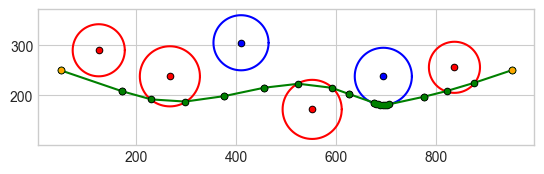

In [5]:
random.seed(29)

x_lim = 1000
y_lim = 500
num_circles = 6 + 1

source = Coord(50, 250)
target = Coord(950, 250)

split_lines = list(range(55, 950, int(x_lim / num_circles)))

obstacles_idx = [2, 4]
circles = []
circles_obstacles = []
for i, split1, split2 in zip(range(len(split_lines)), split_lines[:-1], split_lines[1:]):
    c_x  = (split1 + split2) / 2
    c_y = 250 + random.randint(-100, 100)
    c_r = random.randint(50, int(0.9 * min([c_x - split1, split2 - c_x, y_lim - c_y, c_y])))
    circle = Circle(center=Coord(c_x, c_y), radius=c_r)
    if not i in obstacles_idx:
        circles.append(circle)
    circles_obstacles.append(circle)

budget = 250

sum_of_radii = sum([c.radius for c in circles])
alphas = [c.radius / sum_of_radii if not i_c in obstacles_idx else 0 for i_c, c in enumerate(circles_obstacles)]
path, length, risk = multiple_threats_shortest_path_with_budget_constraint_given_order_and_budgets(
    source, target, circles_obstacles, budget=budget, alphas=alphas)

plt.gca().set_aspect('equal', adjustable='box')
source.plot()
target.plot()
for i, co in enumerate(circles_obstacles):
    if i in obstacles_idx:
        co.plot(color='blue')
    else:
        co.plot()

path.plot()
plt.show()

running for seed 10
running analytical algorithm
running analytical algorithm
running visibility algorithm


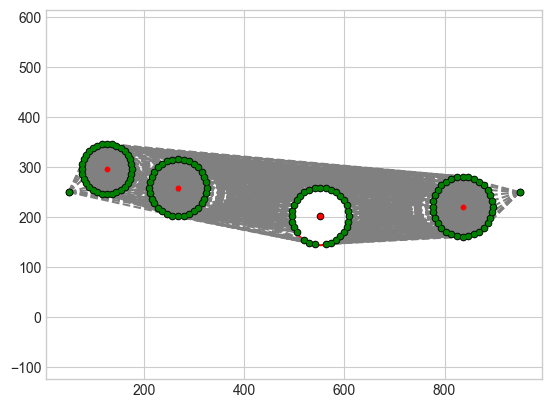

running layers algorithm


100%|███████████████████████████████████████| 2000/2000 [00:20<00:00, 95.81it/s]


In [ ]:
x_lim = 1000
y_lim = 500
num_circles = 6 + 1

source = Coord(50, 250)
target = Coord(950, 250)

f = open('few_obstacles.csv', "a")

for i in range(10, 20):
    print(f'running for seed {i}')
    random.seed(i)

    split_lines = list(range(55, 950, int(x_lim / num_circles)))

    obstacles_idx = [2, 4]
    circles = []
    circles_obstacles = []
    for i, split1, split2 in zip(range(len(split_lines)), split_lines[:-1], split_lines[1:]):
        c_x  = (split1 + split2) / 2
        c_y = 250 + random.randint(-100, 100)
        c_r = random.randint(50, int(0.9 * min([c_x - split1, split2 - c_x, y_lim - c_y, c_y])))
        circle = Circle(center=Coord(c_x, c_y), radius=c_r)
        if not i in obstacles_idx:
            circles.append(circle)
        circles_obstacles.append(circle)

    for budget in [0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]:
    # for budget in [200, 300, 400, 500]:
        # *** partition_radius ***
        start = time.time()
        sum_of_radii = sum([c.radius for c in circles])
        alphas = [c.radius / sum_of_radii if not i_c in obstacles_idx else 0 for i_c, c in enumerate(circles_obstacles)]
        path, length, risk = multiple_threats_shortest_path_with_budget_constraint_given_order_and_budgets(
            source, target, circles, budget=budget, alphas=alphas)
        elapsed = time.time() - start
        f.write(f'partition_radius,{i},{len(circles)},{budget},{length},{risk},{elapsed},{time.time()}' + '\n')

        # *** partition_st ***
        start = time.time()
        sum_of_dists = sum([abs(c.center.y - source.y) for c in circles])
        alphas = [abs(c.center.y - source.y) / sum_of_dists if not i_c in obstacles_idx else 0 for i_c, c in enumerate(circles_obstacles)]
        path, length, risk = multiple_threats_shortest_path_with_budget_constraint_given_order_and_budgets(
            source, target, circles, budget, alphas=alphas)
        elapsed = time.time() - start
        f.write(f'partition_st,{i},{len(circles)},{budget},{length},{risk},{elapsed},{time.time()}' + '\n')

        try:
            # *** visibility ***
            start = time.time()
            path, length, risk = exaustive_layers_multiple_threats_shortest_path_with_budget_constraint(
                source, target, circles, budget, obstacles_idx=obstacles_idx)
            elapsed = time.time() - start
            f.write(f'visibility,{i},{len(circles)},{budget},{length},{risk},{elapsed},{time.time()}' + '\n')
        except:
            print(f'failed to do visibility with seed {i}')

        # *** layers solver ***
        start = time.time()
        path, length, risk = rrg_layers_multiple_threats_shortest_path_with_budget_constraint(
            source, target, circles, budget=budget, obstacles_idx=obstacles_idx)
        elapsed = time.time() - start
        f.write(f'layers_solver,{i},{len(circles)},{budget},{length},{risk},{elapsed},{time.time()}' + '\n')

f.close()

In [ ]:
data = pd.read_csv('few_obstacles.csv', header=0, index_col=False)

In [21]:
data

,method,seed,num_circles,budget,length,risk,elapsed,ts
0,partition_radius,5,4,100,934.987398,100.000000,0.537996,1.699007e+09
1,partition_st,5,4,100,936.622240,100.000000,0.425568,1.699007e+09
2,solver,5,4,100,938.861657,85.142469,29.636102,1.699007e+09
3,partition_radius,5,4,100,902.939280,100.000000,0.326608,1.699007e+09
4,partition_st,5,4,100,904.250289,100.000000,0.313340,1.699007e+09
...,...,...,...,...,...,...,...,...
64,solver,5,4,400,901.517782,0.000090,49.496254,1.699773e+09
65,partition_radius,5,4,500,900.041579,500.000000,0.181186,1.699773e+09
66,partition_st,5,4,500,900.041579,500.000000,0.183961,1.699773e+09
67,exhaustive,5,4,500,900.020087,0.000090,3.003844,1.699773e+09


In [22]:
mean_data = data.groupby(['method', 'num_circles', 'budget']).mean().reset_index()
# methods = list(set(mean_data['method']))
methods = ['solver', 'partition_radius', 'partition_st', 'exhaustive']
budgets = sorted(list(set(mean_data['budget'])))
linestyles = ['--','-.',':','--']

In [23]:
# cur_df = mean_data.loc[mean_data['method'] == 'exhaustive']
# cur_df['length']

Text(0, 0.5, 'computation time')

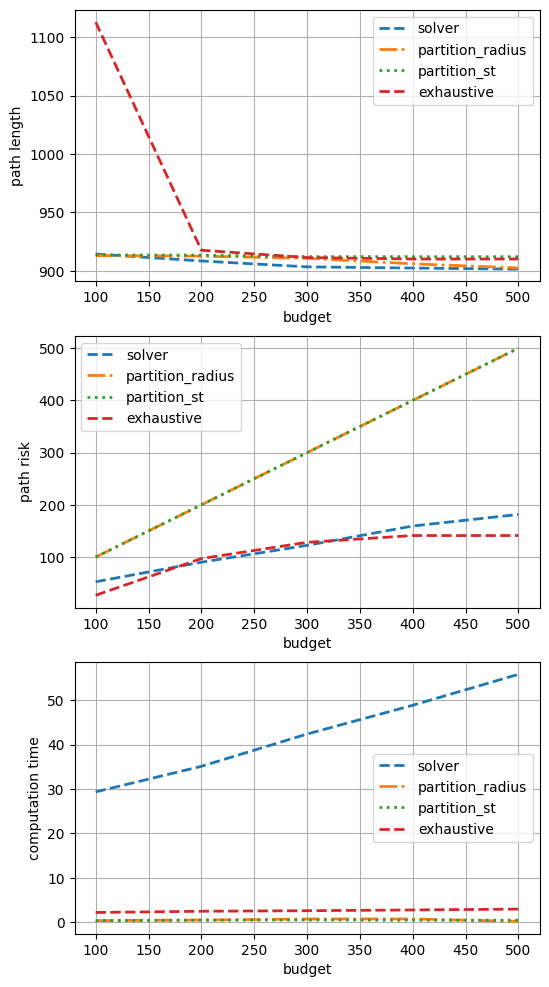

In [24]:
plt.figure(figsize=(6, 12))
plt.subplot(3, 1, 1)
for i, method in enumerate(methods):
    cur_df = mean_data.loc[mean_data['method'] == method]
    plt.plot(cur_df['budget'], cur_df['length'], linestyle=linestyles[i], linewidth=2)
plt.legend(methods)
plt.grid(True)
plt.xlabel('budget')
plt.ylabel('path length')

plt.subplot(3, 1, 2)
for i, method in enumerate(methods):
    cur_df = mean_data.loc[mean_data['method'] == method]
    plt.plot(cur_df['budget'], cur_df['risk'], linestyle=linestyles[i], linewidth=2)
plt.legend(methods)
plt.grid(True)
plt.xlabel('budget')
plt.ylabel('path risk')

plt.subplot(3, 1, 3)
for i, method in enumerate(methods):
    cur_df = mean_data.loc[mean_data['method'] == method]
    plt.plot(cur_df['budget'], cur_df['elapsed'], linestyle=linestyles[i], linewidth=2)
plt.legend(methods)
plt.grid(True)
plt.xlabel('budget')
plt.ylabel('computation time')